<a href="https://colab.research.google.com/github/syedzaidi-kiwi/LLM-Cookbooks/blob/main/Information_extraction_raven_via_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧪🐦‍⬛ Needle in a Jungle - Information Extraction via LLMs

<a target="_blank" href="https://colab.research.google.com/github/deepset-ai/haystack-cookbook/blob/main/notebooks/information_extraction_raven.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="200"/>
</a>

<img src="https://haystack.deepset.ai/images/haystack-ogimage.png" width="430" style="display:inline;">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img src="https://huggingface.co/Nexusflow/NexusRaven-V2-13B/resolve/main/NexusRaven.png" width="250" style="display:inline;">

*Notebook by [Syed Asad](https://huggingface.co/syedzaidi-kiwi)*

In this experiment, we will use Large Language Models to perform Information Extraction from textual data.

🎯 Goal: create an application that, given a URL and a specific structure provided by the user, extracts information from the source.

The "**function calling**" capabilities of OpenAI models unlock this task: the user can describe a structure, by defining a mock up function with all its typed and specific parameters. The LLM will prepare the data in this specific form and send it back to the user.

A nice example of using OpenAI Function Calling for information extraction is this [gist by Kyle McDonald](https://gist.github.com/kylemcdonald/dbac21de2d7855633689f5526225154c).

**What is changing now is that open models such as NexusRaven are emerging, with function calling capabilities...**

*This is an improved version of an older experiment, using Gorilla Open Functions*


**Stack**
- **[NexusRaven](https://huggingface.co/Nexusflow/NexusRaven-V2-13B)**: an open-source and commercially viable function calling model that surpasses the state-of-the-art in function calling capabilities.
- **[Haystack](https://haystack.deepset.ai/)**: open-source LLM orchestration framework that streamlines the development of your LLM applications.

>[🧪🐦‍⬛ Needle in a Jungle - Information Extraction via LLMs](#scrollTo=8Ksv005GbN2w)

>>[Install the dependencies](#scrollTo=Qd4cBgege7PW)

>>[Load and try the model](#scrollTo=-3GvBu0Ffp9I)

>>[Prompt template and Prompt Builder](#scrollTo=uXiUvn0dsNj6)

>>[Other Components](#scrollTo=vlqZUbLqyTtT)

>>[Define a custom Component to parse and visualize the result](#scrollTo=ASq0gDuZ1Vn_)

>>[Create an Information Extraction Pipeline](#scrollTo=pAMBYA7ZFEk0)

>>[🕹️ Try our application!](#scrollTo=furABTbcV57u)

>>[⚠️ Caveats and 🔮 future directions](#scrollTo=mG-W-d9Le-sp)

>>[📚 References](#scrollTo=xNAXyTefgpRX)



## Install the dependencies

In [1]:
%%capture
! pip install transformers haystack-ai

## Load and try the model
We use the [`HuggingFaceTGIGenerator`](https://docs.haystack.deepset.ai/docs/huggingfacetgigenerator), which allows to use models hosted on Hugging Face endpoints.
In particular, we use a paid endpoint kindly provided by Nexusflow to test the LLM.

Alternative inference options:
- load the model on Colab using the HuggingFaceLocalGenerator. This is a bit impractical because the model is quite big (13B parameters) and even using quantization, there would be few GPU resources left for inference.
- local inference via TGI or vLLM: this is a good option if you have GPU avalaible.
- local inference via Ollama/llama.cpp: this is suitable for machines with few resources and no GPU. Keep in mind that in this case a quantized GGUF version of the model would be used, with lower quality than the original model.

In [2]:
from haystack.components.generators import HuggingFaceTGIGenerator

generator = HuggingFaceTGIGenerator(model="Nexusflow/NexusRaven-V2-13B",
                                    url="http://38.142.9.20:10240",
                                    stop_words=["<bot_end>"],
                                    generation_kwargs={"temperature":0.001,
                                                      "do_sample" : False,
                                                       "max_new_tokens" : 1000})
generator.warm_up()

tokenizer_config.json:   0%|          | 0.00/985 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

To understand how to prompt the model, give a look at the [Prompting notebook](https://github.com/nexusflowai/NexusRaven-V2/blob/master/How-To-Prompt.ipynb).
Later we will see how to better organize the prompt for our purpose.

In [3]:
prompt='''
Function:
def get_weather_data(coordinates):
    """
    Fetches weather data from the Open-Meteo API for the given latitude and longitude.

    Args:
    coordinates (tuple): The latitude of the location.

    Returns:
    float: The current temperature in the coordinates you've asked for
    """

Function:
def get_coordinates_from_city(city_name):
    """
    Fetches the latitude and longitude of a given city name using the Maps.co Geocoding API.

    Args:
    city_name (str): The name of the city.

    Returns:
    tuple: The latitude and longitude of the city.
    """

User Query: What's the weather like in Seattle right now?<human_end>

'''

In [4]:
print(generator.run(prompt=prompt))

{'replies': ["Call: get_weather_data(coordinates=get_coordinates_from_city(city_name='Seattle'))"], 'meta': [{'model': 'http://38.142.9.20:10240', 'index': 0, 'finish_reason': 'stop_sequence', 'usage': {'completion_tokens': 29, 'prompt_tokens': 188, 'total_tokens': 217}}]}


All good! ✅

## Prompt template and Prompt Builder

- The Prompt template to apply is model specific. In our case, we customize a bit the original prompt which is available on [Prompting notebook](https://github.com/nexusflowai/NexusRaven-V2/blob/master/How-To-Prompt.ipynb).
- In Haystack, the prompt template is rendered using the [Prompt Builder component](https://docs.haystack.deepset.ai/docs/promptbuilder).

In [5]:
from haystack.components.builders import PromptBuilder

prompt_template = '''
Function:
{{function}}
User Query: Save data from the provided text. START TEXT:{{docs[0].content|replace("\n"," ")|truncate(10000)}} END TEXT
<human_end>'''

prompt_builder = PromptBuilder(template=prompt_template)

In [6]:
# let's see if the Prompt Builder works properly

from haystack import Document
print(prompt_builder.run(docs=[Document(content="my fake document")], function="my fake function definition"))

{'prompt': '\nFunction:\nmy fake function definition\nUser Query: Save data from the provided text. START TEXT:my fake document END TEXT\n<human_end>'}


Nice ✅

## Other Components

The following Components are required for the Pipeline we are about to create. However, they are simple and there is no need to customize and try them, so we can instantiate them directly during Pipeline creation.

- [LinkContentFetcher](https://docs.haystack.deepset.ai/docs/linkcontentfetcher): fetches the contents of the URLs you give it and returns a list of content streams.
- [HTMLToDocument](https://docs.haystack.deepset.ai/docs/htmltodocument): converts HTML files to Documents.
- [DocumentCleaner](https://docs.haystack.deepset.ai/docs/documentcleaner): make text documents more readable.



## Define a custom Component to parse and visualize the result

The output of the model generation is a function call string.

We are going to create a simple Haystack Component to appropriately parse this string and create a nice HTML visualization.

For more information on Creating custom Components, see the [docs](https://docs.haystack.deepset.ai/docs/custom-components).

In [7]:
from haystack import component
from typing import List, Optional
import ast
import re

def val_to_color(val):
  """
  Helper function to return a color based on the type/value of a variable
  """
  if isinstance(val, list):
    return "#FFFEE0"
  if val is True:
    return "#90EE90"
  if val is False:
    return "#FFCCCB"
  return ""

@component
class FunctionCallParser:
  """
  A component that parses the function call string and creates a HTML visualization
  """
  @component.output_types(html_visualization=str)
  def run(self, replies:List[str]):

    print(replies)

    func_call_str = replies[0].replace("Call:", "").strip()

    # sometimes the model output contains wrong expressions like "'date=[...]" or "date'=..."
    # that can't be correctly parsed, so we remove these substrings
    func_call_str=func_call_str.replace("'=","=")
    func_call_str=re.sub("'([a-z]+)=", "\g<1>=", func_call_str)

    func_call=ast.parse(func_call_str).body[0].value
    kwargs = {arg.arg: ast.literal_eval(arg.value) for arg in func_call.keywords}

    # Convert data to HTML format
    html_content = '<div style="border: 1px solid #ccc; padding: 10px; border-radius: 5px; background-color: #f9f9f9;">'
    for key, value in kwargs.items():
        html_content += f'<p><span style="font-family: Cursive; font-size: 30px;">{key}:</span>'
        html_content += f'&emsp;<span style="background-color:{val_to_color(value)}; font-family: Cursive; font-size: 20px;">{value}</span></p>'
    html_content += '</div>'

    return {"html_visualization": html_content}

## Create an Information Extraction Pipeline

To combine the Components in an appropriate and reproducible way, we resort to Haystack Pipelines.
The syntax should be easily understood. You can find more infomation [in the docs](https://docs.haystack.deepset.ai/docs/pipelines).

This pipeline will extract the information from the given URL following the provided structure.

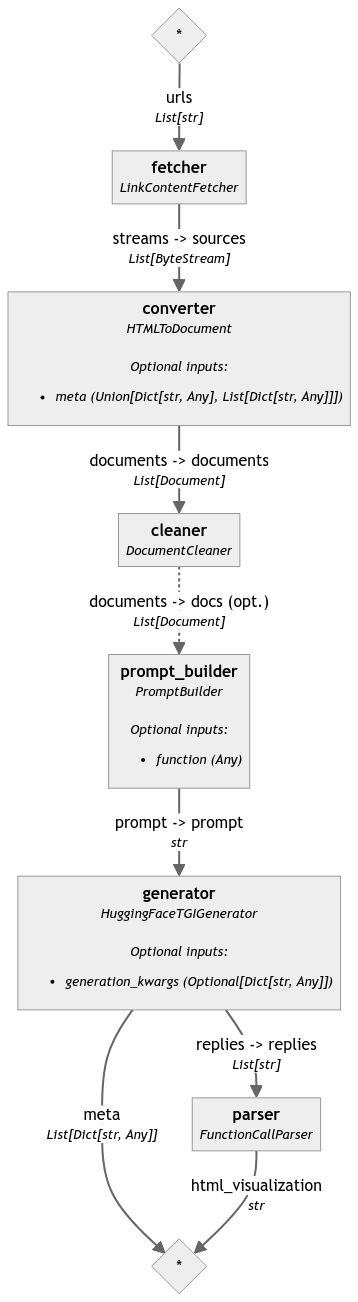

In [8]:
from haystack import Pipeline
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.preprocessors import DocumentCleaner

pipe = Pipeline()

pipe.add_component("fetcher", LinkContentFetcher())
pipe.add_component("converter", HTMLToDocument(extractor_type="DefaultExtractor"))
pipe.add_component("cleaner", DocumentCleaner())
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("generator", generator)
pipe.add_component("parser", FunctionCallParser())

pipe.connect("fetcher", "converter")
pipe.connect("converter", "cleaner")
pipe.connect("cleaner.documents", "prompt_builder.docs")
pipe.connect("prompt_builder", "generator")
pipe.connect("generator", "parser")

Now we create an `extract` function that wraps the Pipeline and displays the result in the HTML format.
This will accept:
- a `function` dict, containing the structure definition of the information we want to extract
- a `url`, to use as data source

In [9]:
from IPython.display import display, HTML

def extract(function:str, url:str) -> dict:
  if not function:
    raise ValueError("function definition is needed")
  if not url:
    raise ValueError("URL is needed")

  data_for_pipeline = {"fetcher":{"urls":[url]},
                       "prompt_builder":{"function":function}}

  html_visualization = pipe.run(data=data_for_pipeline)['parser']['html_visualization']
  display(HTML(html_visualization))

## 🕹️ Try our application!

Let's first define the structure to extract.

We are going to parse some news articles about animals... 🦆🐻🦌

In [10]:
function = '''def save_data(about_animals: bool, about_ai: bool, habitat:List[string], predators:List[string], diet:List[string]):
    """
    Save data extracted from source text

    Args:
    about_animals (bool): Is the article about animals?
    about_ai (bool): Is the article about artificial intelligence?
    habitat (List[string]): List of places where the animal lives
    predators (List[string]): What are the animals that threaten them?
    diet (List[string]): What does the animal eat?
    """'''

Let's start with an article about **Capybaras**

In [11]:
extract(function=function, url="https://www.rainforest-alliance.org/species/capybara/")

["\nCall: save_data(about_animals=True, about_ai=False, habitat=['Panama', 'Colombia', 'Venezuela', 'Guyana', 'Peru', 'Brazil', 'Paraguay', 'Northeast Argentina', 'Uruguay'], predators=['jaguars', 'caimans', 'anacondas', 'ocelots', 'harpy eagles'], diet=['vegetation', 'grass', 'grains', 'melons', 'reeds', 'squashes'])"]


Now let's try with an article about the **Andean cock of the rock**

In [12]:
extract(function=function, url="https://www.rainforest-alliance.org/species/cock-rock/")

["\nCall: save_data(about_animals=True, about_ai=False, habitat=['Andes'], predators=['birds of prey', 'puma', 'jaguars', 'boa constrictors'], diet=['fruit', 'insects', 'small vertebrates'])"]


Now, the **Yucatan Deer**!

In [13]:
extract(function=function, url="https://www.rainforest-alliance.org/species/yucatan-deer/")

["\nCall: save_data(about_animals=True, about_ai=False, habitat=['forests', 'deciduous forests', 'forest edges', 'open fields'], predators=['cougar', 'jaguar'], diet=['grass', 'leaves', 'sprouts', 'lichens', 'mosses', 'tree bark', 'fruit'])"]


A completely different example, about AI...

In [14]:
function='''def save_data(people:List[string], companies:List[string], summary:string, topics:List[string], about_animals: bool, about_ai: bool):
    """
    Save data extracted from source text

    Args:
    people (List[string]): List of the mentioned people
    companies (List[string]): List of the mentioned companies.
    summary (string): Summarize briefly what happened in one sentence of max 15 words.
    topics (List[string]): what are the five most important topics?
    about_animals (bool): Is the article about animals?
    about_ai (bool): Is the article about artificial intelligence?
    """'''


In [15]:
extract(function=function, url="https://www.theverge.com/2023/11/22/23967223/sam-altman-returns-ceo-open-ai")

["\nCall: save_data(people=['Sam Altman', 'Greg Brockman', 'Bret Taylor', 'Larry Summers', 'Adam D’Angelo', 'Satya Nadella', 'Thrive Capital', 'Kelly Sims', 'Helen Toner', 'Ilya Sutskever', 'Emmett Shear'], companies=['OpenAI', 'Microsoft'], summary='Sam Altman will return as CEO of OpenAI, overcoming an attempted boardroom coup that sent the company into chaos over the past several days.', topics=['OpenAI', 'Artificial intelligence', 'Machine learning', 'Computer vision', 'Natural language processing'], about_animals=False, about_ai=True)"]


In [16]:
extract(function=function, url="https://www.theguardian.com/business/2023/dec/30/sam-bankman-fried-will-not-face-second-trial-after-multibillion-dollar-crypto-conviction")

["\nCall: save_data(people=['Sam Bankman-Fried'], companies=['FTX'], summary='Sam Bankman-Fried will not face second trial after multibillion-dollar crypto fraud conviction', topics=['crypto fraud', 'FTX', 'cryptocurrency exchange'], about_animals=False, about_ai=False)"]


In [17]:
extract(function=function, url="https://lite.cnn.com/2023/11/05/tech/nvidia-amd-ceos-taiwan-intl-hnk/index.html")

["\nCall: save_data(people=['Michelle Toh', 'Wayne Chang', 'Jensen Huang', 'Lisa Su'], companies=['Nvidia', 'AMD'], summary='The Taiwanese American cousins going head-to-head in the global AI race', topics=['chip industry', 'global AI chip industry', 'Taiwanese descent', 'semiconductors', 'generative AI'], about_animals=False, about_ai=True)"]


## ✨ Conclusions and caveats
- Nexus Raven seems to work much better than Gorilla Open Functions (v0) for this use case.
- I would also expect it to work significantly better than generic models to which grammars are added to make them produce JSON.
- ⚠️ When the content of the web page is cluttered with extraneous information such as advertisements and interruptions, the model encounters difficulty in extracting relevant information, leading to occasional instances where it returns empty responses.
- ⚠️ As a statistical model, the LLM is highly responsive to prompts. For instance, modifying the order and description of the specified arguments can yield different extraction results.

## 📚 References
*Related to the experiment*
- [Haystack LLM framework](https://haystack.deepset.ai/)
- [Using OpenAI Function Calling for Information Extraction: gist by Kyle McDonald](https://gist.github.com/kylemcdonald/dbac21de2d7855633689f5526225154c)
- [NexusRaven-V2: Surpassing GPT-4 for Zero-shot Function Calling](https://nexusflow.ai/blogs/ravenv2)